# Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

from collections import defaultdict

In [3]:
DATA_DIR = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted"
SPLIT = "train"  # or "val", "test"
NUM_SAMPLES = 2

In [ ]:
index_path = os.path.join(DATA_DIR, f"{SPLIT}_index.csv")
images_path = os.path.join(DATA_DIR, SPLIT)

In [ ]:
# --- Load index ---
samples = []
with open(index_path, newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        samples.append((row["filename"], int(row["label"])))

# --- Pick random samples ---
random_samples = random.sample(samples, min(NUM_SAMPLES, len(samples)))

In [ ]:
# --- Plot central slices from 3D volumes ---
fig, axes = plt.subplots(1, NUM_SAMPLES, figsize=(15, 3))
if NUM_SAMPLES == 1:
    axes = [axes]

for ax, (filename, label) in zip(axes, random_samples):
    img_path = os.path.join(images_path, filename)
    vol = np.load(img_path)  # Shape: (D, H, W)
    
    
    if vol.ndim == 4:
        vol = vol[0]
    center_slice = vol.shape[0] // 2
    img = vol[center_slice, :, :]  # Get the central axial slice

    ax.imshow(img, cmap="gray")
    ax.set_title(f"{filename}\nLabel: {'Cancer' if label == 1 else 'Non-cancer'}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def debug_show_middle_slice(vol):
    mid = vol.shape[0] // 2
    plt.imshow(vol[:, :, mid], cmap="gray")
    plt.title("Middle slice of volume")
    plt.axis("off")
    plt.show()

In [4]:
# --- Configuration ---
SPLITS = ["train", "val", "test"]

def extract_patient_id(filename):
    # Extracts patient ID assuming filename format: "LIDC-IDRI-XXXX_sliceX.npy" or "LIDC-IDRI-XXXX_X_augY.npy"
    return filename.split('_')[-1]

In [ ]:
for split in SPLITS:
    index_path = os.path.join(DATA_DIR, f"{split}_index.csv")
    summary = defaultdict(list)  # label -> [patient_ids]

    with open(index_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            label = int(row["label"])
            label_str = "cancer" if label == 1 else "non-cancer"
            patient_id = extract_patient_id(row["patient_id"])
            summary[label_str].append(patient_id)

    # Count and deduplicate
    stat_path = os.path.join(DATA_DIR, f"{split}_summary.csv")
    with open(stat_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Class", "Num Samples", "Num Unique Patients"])
        for cls, patients in summary.items():
            writer.writerow([cls, len(patients), len(set(patients))])

    print(f"[✓] Saved summary for {split} to {stat_path}")

In [ ]:
sample_file = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy"
img = np.load(sample_file)

print("dtype:", img.dtype)
print("min:", img.min())
print("max:", img.max())
print("mean:", img.mean())
print("std:", img.std())

In [ ]:
sample_file = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/non-cancer/LIDC-IDRI-0162_org.npy"
img = np.load(sample_file)

print("dtype:", img.dtype)
print("min:", img.min())
print("max:", img.max())
print("mean:", img.mean())
print("std:", img.std())

In [ ]:
import numpy as np

# Load one sample from your dataset
volume = np.load("/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy")

print("Shape of the volume:", volume.shape)

In [5]:
import os
import csv
import torch

import numpy as np
import pandas as pd
from io import StringIO

from tqdm import tqdm
import matplotlib.pyplot as plt

from monai.transforms import (
    Compose, 
    Resize, 
    RandAdjustContrast,
    Compose, 
    Resize, 
    RandRotate, 
    RandZoom,
    RandFlip,
    RandAffine,
    RandBiasField
)

/home/vivianea/apps/miniconda3/envs/lidc_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
IMAGE_SIZE = (256, 256, 256)

PATH_TRAIN = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train'
PATH_TEST = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/test'
PATH_VAL = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/val'

CSV_TRAIN = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train_index.csv'
CSV_TEST = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/test_index.csv'
CSV_VAL = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/val_index.csv'

SAVE_DIR = "/home/vivianea/projects/BrainInnov/data/npy_3D_augmented"

NUM_AUGMENTATION = 1

In [7]:
def get_transforms(IMAGE_SIZE):
    return Compose([
        # RandFlip(spatial_axis=0, prob=0.5),
        # RandFlip(spatial_axis=1, prob=0.5),
        # RandFlip(spatial_axis=2, prob=0.5),
        # RandRotate(range_x=0.2, range_y=0.2, range_z=0.2, prob=0.4),
        # RandAffine(
        #    rotate_range=(0.1, 0.1, 0.1),
        #    translate_range=(4, 4, 4),  # slightly reduced to avoid artifacts
        #    scale_range=(0.05, 0.05, 0.05),  # less scale distortion
        #    prob=0.3
        #),
        # RandBiasField(coeff_range=(0.0, 0.05), prob=0.2),
        # RandAdjustContrast(prob=0.2, gamma=(0.8, 1.3)),
        # RandZoom(min_zoom=0.95, max_zoom=1.05, prob=0.2),
        Resize(spatial_size=IMAGE_SIZE, mode="trilinear")
    ])

In [8]:
def apply_augmentation_and_plot(volume_path, label, patient_id, num_aug=NUM_AUGMENTATION, image_size=IMAGE_SIZE):
    """
    Applies augmentation to a single 3D volume and plots original vs. augmented slices.

    Args:
        volume_path (str): Full path to the .npy volume file.
        label (int): The label associated with this volume (e.g., 0 for non-cancer, 1 for cancer).
        patient_id (str): The patient ID for this volume.
        num_aug (int): Number of augmented versions to generate and plot.
        image_size (tuple): The target spatial size for resizing (D, H, W).
    """
    transform = get_transforms(image_size) # Ensure get_transforms takes image_size

    try:
        volume = np.load(volume_path).astype(np.float32)
    except Exception as e:
        print(f"⚠️ Skipping {patient_id} from {volume_path}: {e}")
        return

    if volume.ndim == 3:
        volume = np.expand_dims(volume, axis=0)  # (1, D, H, W)

    volume_tensor = torch.from_numpy(volume)

    # Apply initial resize to the original volume for consistent plotting with augmented
    # If your original volumes are not already IMAGE_SIZE, this ensures comparison
    initial_transform = Compose([Resize(spatial_size=image_size, mode="trilinear")])
    volume_tensor_resized = initial_transform(volume_tensor)
    
    # Calculate center slice for the original (resized) volume
    depth_orig = volume_tensor_resized.shape[1]
    center_slice_orig = depth_orig // 2
    slice_img_orig = volume_tensor_resized[0, center_slice_orig, :, :].cpu().numpy() # Convert to numpy

    # Plot Original Image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, num_aug + 1, 1) # One subplot for original, num_aug for augmented
    plt.imshow(slice_img_orig, cmap="gray")
    plt.title(f"Original - {patient_id}\nLabel: {label}")
    plt.axis("off")

    for n in range(num_aug):
        augmented_tensor = transform(volume_tensor.clone()) # Clone before augmentation
        
        # Make sure augmented_tensor is on CPU and convert to numpy
        augmented_np = augmented_tensor.cpu().numpy()

        # Extract a slice from the augmented volume
        # Assuming [C, D, H, W] after augmentation and resizing
        depth_aug = augmented_np.shape[1]
        center_slice_aug = depth_aug // 2 # Use center slice of augmented volume
        
        # Ensure that `augmented_np` is still (C, D, H, W)
        if augmented_np.ndim == 4 and augmented_np.shape[0] == 1:
            slice_img_aug = augmented_np[0, center_slice_aug, :, :] # [C, D, H, W] -> [H, W]
        else:
            # Fallback for unexpected dimensions, or if C is > 1
            print(f"Warning: Augmented volume has unexpected shape {augmented_np.shape}. Plotting first channel.")
            if augmented_np.ndim == 4:
                slice_img_aug = augmented_np[0, center_slice_aug, :, :]
            else: # If somehow it became 3D (D,H,W), take a slice
                slice_img_aug = augmented_np[center_slice_aug, :, :]


        plt.subplot(1, num_aug + 1, n + 2) # Plot in the next subplot position
        plt.imshow(slice_img_aug, cmap="gray")
        plt.title(f"Augmented {n+1}\n{patient_id}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()

# --- How to use this function ---
# Assuming you have your DataFrame 'df' loaded
# For example, if you want to plot the first row:
# df_train = pd.read_csv(CSV_TRAIN) # Load your training CSV
# df_val = pd.read_csv(CSV_VAL) # Load your validation CSV

# Example usage:
# Select a few rows for visualization, don't run on all 20k images!
# For a specific row (e.g., the one you mentioned: LIDC-IDRI-0068)
# If you have 'folder' column to distinguish train/val/test npy_dirs
# (Assuming 'filename' in CSV is just 'LIDC-IDRI-0068_org.npy')

# Get one sample from your training dataframe
# sample_row = df_train[df_train['patient_id'] == 'LIDC-IDRI-0068'].iloc[0] # If you have this specific row
# Or just get the first sample:
# sample_row_train = df_train.iloc[0]
# sample_row_val = df_val.iloc[0]

# full_path_train_sample = os.path.join(PATH_TRAIN, sample_row_train['filename'])
# apply_augmentation_and_plot(
#     volume_path=full_path_train_sample,
#     label=sample_row_train['label'],
#     patient_id=sample_row_train['patient_id'],
#     num_aug=3 # Plot 3 augmented versions
# )

# full_path_val_sample = os.path.join(PATH_VAL, sample_row_val['filename'])
# apply_augmentation_and_plot(
#     volume_path=full_path_val_sample,
#     label=sample_row_val['label'],
#     patient_id=sample_row_val['patient_id'],
#     num_aug=3 # Plot 3 augmented versions
# )

# To demonstrate with your example string:
dummy_data_string = """class,label,filename,folder,patient_id
cancer,1,LIDC-IDRI-0068_org.npy,train,LIDC-IDRI-0068"""
dummy_df = pd.read_csv(StringIO(dummy_data_string))
dummy_row = dummy_df.iloc[0]

# --- Create a dummy .npy file for testing this function ---
# This is just for demonstration if you don't have the actual NPY file handy.
# REMOVE THIS BLOCK when using your real data paths.
dummy_npy_dir = './dummy_npy_data'
os.makedirs(dummy_npy_dir, exist_ok=True)
dummy_volume_path = os.path.join(dummy_npy_dir, dummy_row['filename'])
if not os.path.exists(dummy_volume_path):
    # Create a simple 3D numpy array for testing
    dummy_3d_array = np.random.rand(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]).astype(np.float32) * 255 # Example: 0-255 intensity
    np.save(dummy_volume_path, dummy_3d_array)
    print(f"Created dummy volume at: {dummy_volume_path}")
# --- End of dummy file creation ---


Created dummy volume at: ./dummy_npy_data/LIDC-IDRI-0068_org.npy


In [235]:
# Your data as a multi-line string
data = """class,label,filename,folder,patient_id
cancer,1,/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy,train,LIDC-IDRI-0068"""
# Use StringIO to treat the string as a file, then read with pandas
df = pd.read_csv(StringIO(data))
npy_dir = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy'


--- Plotting Dummy Augmented Image ---


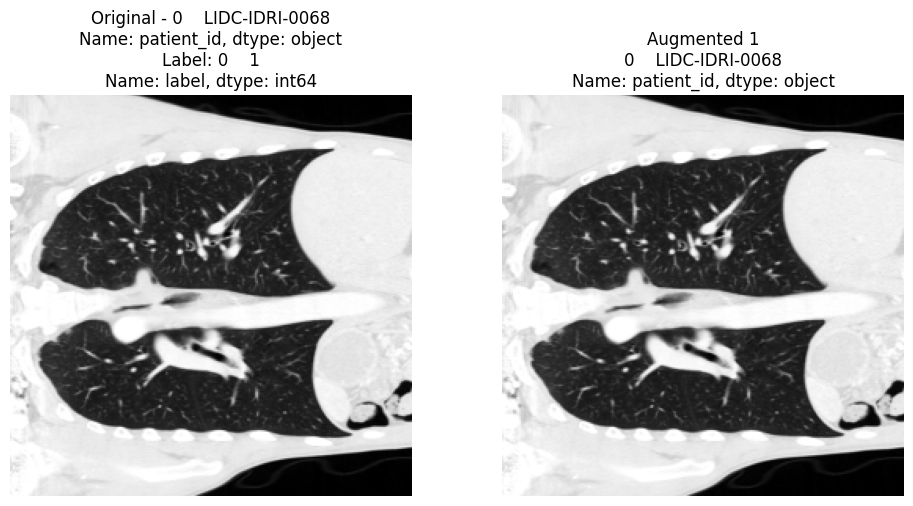

In [236]:
# Now call the function with the dummy data
print("\n--- Plotting Dummy Augmented Image ---")
apply_augmentation_and_plot(
    volume_path=npy_dir,
    label=df['label'],
    patient_id=df['patient_id'],
    num_aug=1, # Plot 3 augmented versions
    image_size=IMAGE_SIZE
)

# You can also run it in a loop for a few samples from your actual dataframe:
# for i in range(min(5, len(df_train))): # Plot first 5 training samples
#     row = df_train.iloc[i]
#     full_path = os.path.join(PATH_TRAIN, row['filename'])
#     apply_augmentation_and_plot(full_path, row['label'], row['patient_id'], num_aug=2, image_size=IMAGE_SIZE)

In [237]:
# Your data as a multi-line string
data = """class,label,filename,folder,patient_id
non-cancer,0,/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/non-cancer/LIDC-IDRI-0168_org.npy,train,LIDC-IDRI-0168"""
# Use StringIO to treat the string as a file, then read with pandas
df = pd.read_csv(StringIO(data))
npy_dir = '/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/non-cancer/LIDC-IDRI-0168_org.npy'

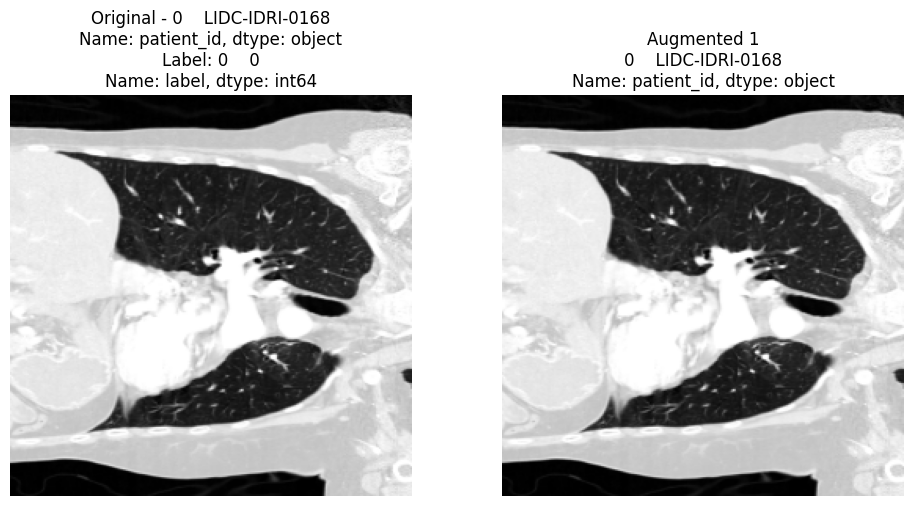

In [238]:
apply_augmentation_and_plot(
    volume_path=npy_dir,
    label=df['label'],
    patient_id=df['patient_id'],
    num_aug=1, # Plot 3 augmented versions
    image_size=IMAGE_SIZE
)

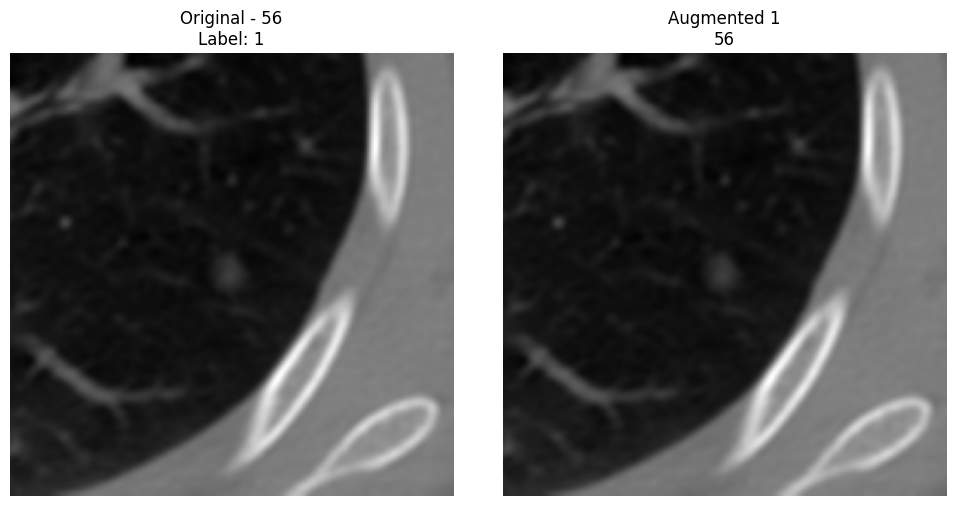

In [16]:
npy_dir = '/home/vivianea/projects/BrainInnov/data/ctvolume/AIS/sample22_AIS.npy'
apply_augmentation_and_plot(
    volume_path=npy_dir,
    label=1,
    patient_id=56,
    num_aug=1, # Plot 3 augmented versions
    image_size=IMAGE_SIZE
)